In [1]:
import numpy as np

# Loss Function 정의

In [2]:
def sum_squares_error(y_pred, y_real):
    result = np.sum((y_real-y_pred)**2)
    return result

def cross_entropy_error(y_pred, y_real, is_onehot = True):
    if y_real.ndim==1:
        y_real = y_real.reshape(1,y_real.size)
        y_pred = y_pred.reshape(1,y_pred.size)

    batch_size = y_pred.shape[0]
    if is_onehot:
        result = -np.sum(y_real * np.log(y_pred+1e-7)) / batch_size
    else:
        result = -np.sum(np.log(y_pred[np.arange(batch_size), y_real] + 1e-7)) / batch_size

    return result

# (사실 필요는 없지만)numerical_grad_정의

In [3]:
def numerical_grad_1d(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        x_i = x[idx]
        
        x[idx] = x_i + h
        f_x_plus_h = f(x)
        
        x[idx] = x_i-h
        f_x_minus_h = f(x)
        
        x[idx] = x_i
        grad[idx] = (f_x_plus_h - f_x_minus_h)/(2*h)
    
    return grad

def numerical_grad_2d(f,x):
    if x.ndim == 1:
        grad = numerical_grad_1d(f,x)
    else:
        grad = np.zeros_like(x)
        for idx in range(x.shape[0]):
            grad[idx] = numerical_grad_1d(f,x[idx])
    return grad

## Scalar data에 대한 Computational Graph의 forward, backward

In [2]:
class Mullayer:
    def __init__(self):
        self.x = None
        self.y = None 
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        result = x * y
        return result
    
    def backward(self, d_result):
        dx = d_result * self.y
        dy = d_result * self.x 
        return dx, dy
    
class Addlayer:
    def __init__(self):
        self.x = None 
        self.y = None 
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x + y
    
    def backward(self, d_result):
        dx = d_result * 1
        dy = d_result * 1
        return dx, dy

In [4]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        result = x * y
        return result
    
    def backward(self, d_result):
        d_x = d_result * self.y
        d_y = d_result * self.x
        return d_x, d_y

In [5]:
class AddLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        result = x + y
        return x + y
    
    def backward(self, d_result):
        d_x = d_result * 1
        d_y = d_result * 1
        return d_x, d_y

## Activation Function에 대한 forward, backward

In [6]:
class ReLU:
    def __init__(self):
        self.x = None
    
    def forward(self, x):
        self.mask = (x<=0)
        result = x.copy()
        result[self.mask] = 0
        return result
    
    def backward(self, d_result):
        d_result[self.mask] = 0
        d_x = d_result
        return d_x
    

In [7]:
class Sigmoid:
    def __init__(self):
        self.x = None
        
    def forward(self, x):
        result = 1 / (1+np.exp(-x))
        self.result = result
        return result
    
    def backward(self, d_result):
        d_x = d_result * (1.0-self.result) * self.result
        return d_x

## Matrix 연산에 대한 forward, backward

In [8]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.X = None
        self.d_W = None
        self.d_b = None
        
    def forward(self, X):
        self.X = X
        result = np.dot(X, self.W) + self.b
        return result
    
    def backward(self, d_result):
        d_x = np.dot(d_result, self.W.T)
        self.d_W = np.dot(self.X.T, d_result)
        self.d_b = np.sum(d_result, axis=0)
        return d_x

In [9]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y_pred = None
        self.y_real = None
        
    def forward(self, a, y_real): 
        # a: softmax를 통과하기 전, 최종 출력층의 뉴런에 모이는 값
        self.y_real = y_real
#         self.y_pred = softmax_prev(a)
        self.y_pred = softmax(a)
        self.loss = cross_entropy_error(self.y_pred, self.y_real)
        return self.loss
    
    def backward(self, d_result):
        batch_size = self.y_real.shape[0]
        d_x = (self.y_pred - self.y_real) / batch_size
        return d_x
        
        

# 이제 MNIST를 분류하는 FFNN을 직접 학습해봅시다

## 이전과 다른점은 이제 backprop이 정의되어 있는 operation을 사용해야 한다는 것 뿐입니다.
### 예를 들면, np.dot함수 대신에 Affine()클래스의 객체를 사용하여 operation을 하는게 있겠네요

<span style = 'font-size:1.2em;line-height:1.5em'>다음과 같은 과정을 수행해야 합니다.</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>1. neural network class 정의하기: 여기선, Two-layer FFNN을 정의하겠습니다.이 클래스에는 다음과 같은 속성과 메소드가 필요합니다.</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>(1)params 속성: </b>Network의 weight들이 들어있는 dictionary.</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>(2)predict() 메소드: </b>Forward Propagation을 진행하는 메소드</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>(3)get_loss() 메소드: </b>predict()의 결과와 실제 레이블을 비교하여 cross entropy loss를 계산하는 메소드</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>(4)get_grad() 메소드: </b>현재 W상태에서 gradient를 산출하는 메소드</span>
    - <span style = 'font-size:1.1em;line-height:1.5em'><b>(5)get_accuracy() 메소드: </b>(Optional) 현재 상태에서 네트워크가 inference하는 결과의 정확도를 산출하는 메소드</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>2. Mini-batch 데이터를 데이터에 입력</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>3. 현재 W상태에서 gradient를 계산</span>
- <span style = 'font-size:1.2em;line-height:1.5em'>4. gradient descent로 learning_rate만큼 이동</span>

In [10]:
from act_fn import *
from mnist import load_mnist
from collections import OrderedDict

In [11]:
class MyNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # parameter 생성
        self.params = dict()
        self.params['W1'] = np.random.randn(input_size, hidden_size) * weight_init_std
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, output_size) * weight_init_std
        self.params['b2'] = np.zeros(output_size)
        
        # Operation들을 np.dot, relu 등의 함수 대신 Affine, ReLU등의 클래스에서 생성한 인스턴스 사용
        # OrderedDict를 써서 순서대로 연산하라는 명시를 하지만, 이제는 그냥 Dict를 써도 되긴 합니다.
        self.layers = OrderedDict()
        self.layers['affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['relu1'] = ReLU()
        self.layers['affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.last_layer = SoftmaxWithLoss()
        
        
    def predict(self, X):
        for layer in self.layers.values():
            X = layer.forward(X)
            
        return X
    
    def get_loss(self, X, y_real):
        y_pred = self.predict(X)
        loss   = self.last_layer.forward(y_pred, y_real)
        
        return loss
    
    def get_accuracy(self, X, y_real):
        y_pred = self.predict(X)
        y_pred = np.argmax(y_pred, axis=1)
        if y_real.ndim!=1:
            y_real = np.argmax(y_real, axis=1)
        
        accuracy = np.sum(y_pred == y_real) / X.shape[0]
        return accuracy
    
    def get_numerical_grad(self, X, y_real):
        loss = lambda W: self.get_loss(X, y_real)
        grads = dict()
        grads['W1'] = numerical_grad_2d(loss, self.params['W1'])
        grads['b1'] = numerical_grad_2d(loss, self.params['b1'])
        grads['W2'] = numerical_grad_2d(loss, self.params['W2'])
        grads['b2'] = numerical_grad_2d(loss, self.params['b2'])
        return grads
    
    def get_grad(self, X, y_real):
        # Forward Prop으로 loss 산출
        self.get_loss(X, y_real)
        
        # Backward Prop
        d_out = 1
        d_out = self.last_layer.backward(d_out)
        
        # Backward prop은 원래 방향과 반대 방향으로 진행됨
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            d_out = layer.backward(d_out)
            
        grads = dict()
        grads['W1'] = self.layers['affine1'].d_W
        grads['b1'] = self.layers['affine1'].d_b
        grads['W2'] = self.layers['affine2'].d_W
        grads['b2'] = self.layers['affine2'].d_b
        
        return grads
        

In [12]:
is_onehot = True
(x_trn, y_trn), (x_tst, y_tst) = load_mnist(normalize=True, 
                                            flatten=True, 
                                            one_hot_label=is_onehot)

In [13]:
network = MyNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 반복횟수
train_size = x_trn.shape[0]
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # print(i)
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_trn[batch_mask]
    t_batch = y_trn[batch_mask]

    # 오차역전파법으로 기울기 계산
    grad = network.get_grad(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.get_loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭 당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.get_accuracy(x_trn, y_trn)
        test_acc = network.get_accuracy(x_tst, y_tst)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


train acc, test acc | 0.07481666666666667, 0.0777
train acc, test acc | 0.9029666666666667, 0.9046
train acc, test acc | 0.9254, 0.9285
train acc, test acc | 0.93735, 0.9394
train acc, test acc | 0.9468666666666666, 0.9464
train acc, test acc | 0.9521833333333334, 0.9514
train acc, test acc | 0.9573, 0.9557
train acc, test acc | 0.9614333333333334, 0.9576
train acc, test acc | 0.9650333333333333, 0.9609
train acc, test acc | 0.9677, 0.9616
train acc, test acc | 0.9707833333333333, 0.9644
train acc, test acc | 0.9728166666666667, 0.9658
train acc, test acc | 0.9742333333333333, 0.9663
train acc, test acc | 0.9755833333333334, 0.9667
train acc, test acc | 0.97765, 0.9698
train acc, test acc | 0.9785833333333334, 0.9695
train acc, test acc | 0.9791333333333333, 0.9701


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

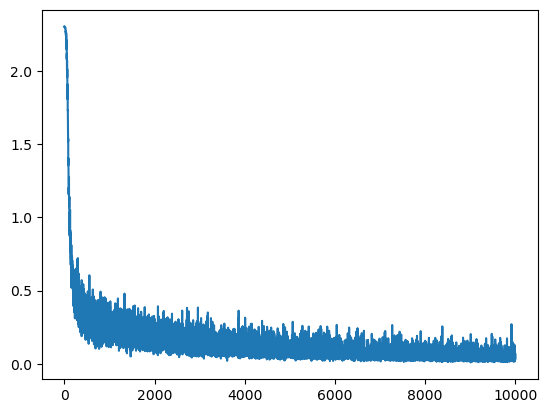

In [15]:
plt.plot(train_loss_list)

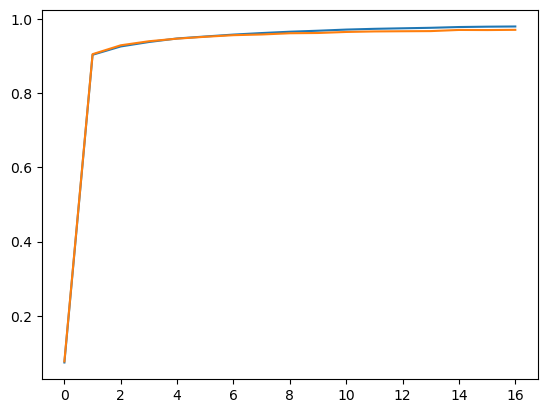

In [16]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)